In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")

In [3]:
x_train = pd.read_csv('../data/processed/x_train_processed.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
x_test = pd.read_csv('../data/processed/x_test_processed.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [4]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

param_grid_knn = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance']
}

param_grid_dt = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

param_grid_lgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1]
}

models = {
    'RandomForestRegressor': (RandomForestRegressor(random_state=42), param_grid_rf),
    'KNeighborsRegressor': (KNeighborsRegressor(), param_grid_knn),
    'DecisionTreeRegressor': (DecisionTreeRegressor(random_state=42), param_grid_dt),
    'LightGBM': (LGBMRegressor(random_state=42), param_grid_lgb)
}

results = {}

for model_name, (model, param_grid) in models.items():
    search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                n_iter=10, cv=2, n_jobs=-1, random_state=42, verbose=1)
    search.fit(x_train, y_train.values.ravel())
    best_model = search.best_estimator_
    y_pred = best_model.predict(x_test)
    
    results[model_name] = {
        'R2': best_model.score(x_test, y_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Best Params': search.best_params_ 
    }

for model_name, result in results.items():
    print(f'{model_name}:')
    print(f"  R²: {result['R2']:.4f}")
    print(f"  RMSE: {result['RMSE']:.4f}")
    print(f"  Best Parameters: {result['Best Params']}")
    print()

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 238352, number of used features: 29
[LightGBM] [Info] Start training from score 252.058499
RandomForestRegressor:
  R²: 0.9851
  RMSE: 33.1933
  Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}

KNeighborsRegressor:
  R²: 0.9712
  RMSE: 46.1511
  Best Parameters: {'weights': 'distance', 'n_neighbors': 5}

DecisionTreeRegressor:
  R²:

In [5]:
from sklearn.model_selection import cross_val_score

best_model = RandomForestRegressor(min_samples_split=5, n_estimators=100, random_state=42, max_depth=20)
scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation RMSE: ", np.mean(np.sqrt(-scores)))

Cross-Validation RMSE:  33.8977755561967


In [6]:
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print("Final Test R²: ", best_model.score(x_test, y_test))
print("Final Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Final Test R²:  0.9851033461662703
Final Test RMSE:  33.19330648364955


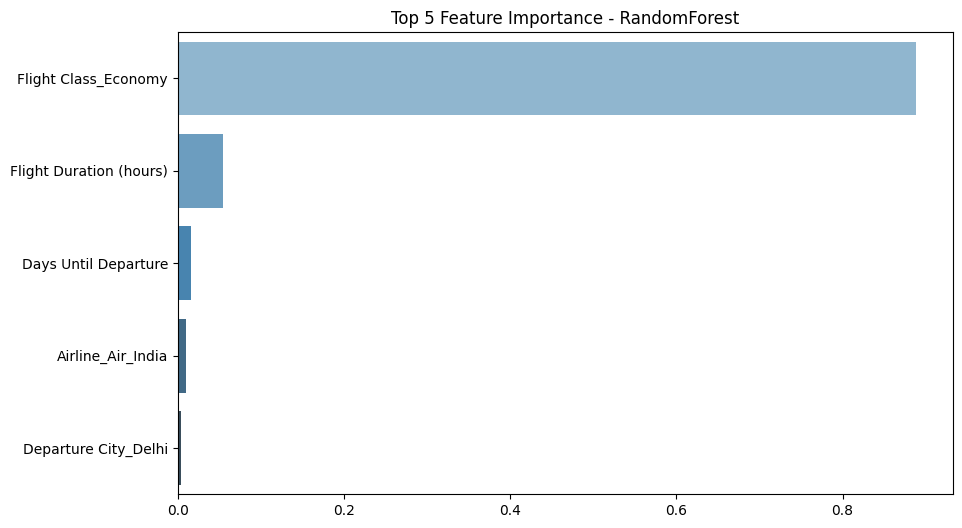

In [17]:
importances = best_model.feature_importances_
feature_names = x_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 5 Feature Importance - RandomForest")
sns.barplot(x=importances[indices][:5], y=[feature_names[i] for i in indices][:5], palette="Blues_d")
plt.show()

In [9]:
top_n = 3
print("Top features:")
for i in range(top_n):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

Top features:
Flight Class_Economy: 0.8881
Flight Duration (hours): 0.0551
Days Until Departure: 0.0156
